## Detecting Marginal Distribution of columns from DataProfiler report
For generating synthetic data, the marginal distribution of each column needs to be known. `synthetic_data.marginal_dist.py` detects/approximates the type of distribution + parameters followed by a column given the DataProfiler report.

Type of distribution selected for each column based on goodness-of-fit test (**Chi-Squared** test for discrete variables, **Kolmogorov-Smirnov** test for continuous variables). 

In [10]:
import dataprofiler as dp
import numpy as np
import pandas as pd
from sklearn import datasets
from synthetic_data.marginal_dist import detect_dist
import matplotlib.pyplot as plt
from scipy import stats

In [11]:
# Load Iris dataset
iris = datasets.load_iris()
data = pd.DataFrame(data=np.c_[iris["data"], iris["target"]], columns=iris["feature_names"] + ["target"])
data.target = data.target.astype(int)
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [12]:
# Generate report
profile_options = dp.ProfilerOptions()
profile_options.set({
    "data_labeler.is_enabled": False,
    "correlation.is_enabled": True,
})

profile = dp.Profiler(data, options=profile_options)

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns...  (with 5 processes)


  0%|          | 0/5 [00:00<?, ?it/s]/Users/HMW373/Documents/synthetic-data/.venv/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:513: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_series = df_series.loc[true_sample_list]
/Users/HMW373/Documents/synthetic-data/.venv/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:513: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_series = df_series.loc[true_sample_list]
 20%|██        | 1/5 [00:03<00:12,  3.20s/it]/Users/HMW373/Documents/synthetic-data/.venv/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:513: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_series = df_series.loc[true_sample_list]
/Users/HMW373/Documents/synthetic-data/.venv/lib/python3.8/site-packages/dataprof

INFO:DataProfiler.profilers.profile_builder: Calculating the statistics...  (with 4 processes)


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


In [13]:
report = profile.report()
report

{'global_stats': {'samples_used': 150,
  'column_count': 5,
  'row_count': 150,
  'row_has_null_ratio': 0.0,
  'row_is_null_ratio': 0.0,
  'unique_row_ratio': 0.9933333333333333,
  'duplicate_row_count': 1,
  'file_type': "<class 'pandas.core.frame.DataFrame'>",
  'encoding': None,
  'correlation_matrix': array([[ 1.        , -0.11756978,  0.87175378,  0.81794113,  0.78256123],
         [-0.11756978,  1.        , -0.4284401 , -0.36612593, -0.42665756],
         [ 0.87175378, -0.4284401 ,  1.        ,  0.96286543,  0.9490347 ],
         [ 0.81794113, -0.36612593,  0.96286543,  1.        ,  0.95654733],
         [ 0.78256123, -0.42665756,  0.9490347 ,  0.95654733,  1.        ]]),
  'chi2_matrix': array([[nan, nan, nan, nan, nan],
         [nan,  1., nan,  0.,  0.],
         [nan, nan, nan, nan, nan],
         [nan,  0., nan,  1.,  0.],
         [nan,  0., nan,  0.,  1.]]),
  'profile_schema': defaultdict(list,
              {'sepal length (cm)': [0],
               'sepal width (cm)': [1

In [14]:
marginal_dist_list = detect_dist(report)
marginal_dist_list

[{'dist': 'norm',
  'args': (5.843333333333334, 0.828066127977863),
  'column': 0,
  'column_name': 'sepal length (cm)'},
 {'dist': 'norm',
  'args': (3.0573333333333337, 0.43586628493669827),
  'column': 1,
  'column_name': 'sepal width (cm)'},
 {'dist': 'norm',
  'args': (3.7580000000000005, 1.7652982332594664),
  'column': 2,
  'column_name': 'petal length (cm)'},
 {'dist': 'skewnorm',
  'args': (-0.1029667476489826, 1.1993333333333336, 0.7622376689603465),
  'column': 3,
  'column_name': 'petal width (cm)'},
 {'dist': 'randint', 'args': (0, 3), 'column': 4, 'column_name': 'target'}]

##### Compare the observed histogram to the detected marginal distributions

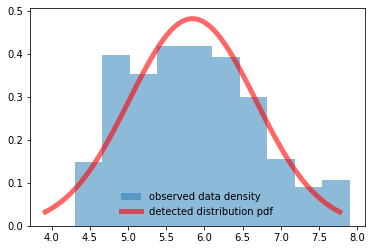

In [15]:
# Plot the histogram and the detected marginal distribution's pdf of a continuous variable column

COL_NUM = 0

fig, ax = plt.subplots(1,1)
cont_data_stats = report['data_stats'][COL_NUM]['statistics']
bin_counts, bin_edges = cont_data_stats['histogram']['bin_counts'], cont_data_stats['histogram']['bin_edges']

hist_dist = stats.rv_histogram((bin_counts, bin_edges))
observed_samples = hist_dist.rvs(size=10000)

ax.hist(observed_samples, density=True,histtype='stepfilled', alpha=0.5, label="observed data density")

detected_dist = marginal_dist_list[COL_NUM]
dist_name, dist_args = detected_dist['dist'], detected_dist['args']

dist_method = getattr(stats, dist_name)
dist_method = dist_method(*dist_args)

x = np.linspace(dist_method.ppf(0.01), dist_method.ppf(0.99), 100)
ax.plot(x, dist_method.pdf(x), 'r-', lw=5, alpha=0.6, label="detected distribution pdf")

ax.legend(loc='best', frameon=False)
plt.show()

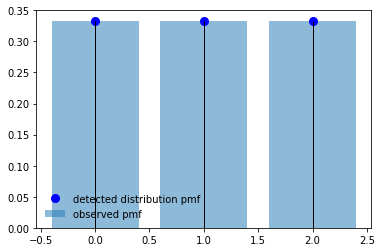

In [16]:
# Plot the histogram and the detected marginal distribution's pmf of a discrete variable column

COL_NUM = 4

fig, ax = plt.subplots(1,1)
disc_data_stats = report['data_stats'][COL_NUM]['statistics']

detected_dist = marginal_dist_list[COL_NUM]
dist_name, dist_args = detected_dist['dist'], detected_dist['args']

dist_method = getattr(stats, dist_name)
dist_method = dist_method(*dist_args)

categories = [int(category) for category in disc_data_stats['categories']]
categories.sort()
categorical_count = {int(k): v for k, v in disc_data_stats['categorical_count'].items()}

ax.plot(categories, dist_method.pmf(categories), 'bo', ms=8, label="detected distribution pmf")
ax.vlines(categories, 0, dist_method.pmf(categories), colors='k', linestyles='-', lw=1)

bar_heights = np.asarray([categorical_count[category] for category in categories])
bar_heights = bar_heights / np.sum(bar_heights)
ax.bar(categories, bar_heights, alpha=0.5, label="observed pmf")

ax.legend(loc='best', frameon=False)
plt.show()